<a href="https://colab.research.google.com/github/Akashsampangirama/ImageML/blob/main/TensorFlow_ImageSegmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/CelebAMask-HQ.zip",'r') as z:
  z.extractall()

In [3]:
!mkdir mask
#!rm -rf "/content/mask"

In [ ]:
# !rm -rf "/content/train"
# !rm -rf "/content/test"

In [ ]:
#!rm -rf "/content/results"

In [4]:
import os.path as osp
from google.colab.patches import cv2_imshow
import os
import cv2
import numpy as np
#from transform import *
from PIL import Image

face_data = '/content/CelebAMask-HQ/CelebA-HQ-img'
face_sep_mask = '/content/CelebAMask-HQ/CelebAMask-HQ-mask-anno'
mask_path = '/content/mask'#'/content/CelebAMask-HQ/mask'
counter = 0
total = 0
for i in range(15):

    atts = ['l_eye', 'r_eye','mouth', 'u_lip', 'l_lip']

    for j in range(i * 2000, (i + 1) * 2000):

        mask = np.zeros((512, 512))

        for l, att in enumerate(atts, 1):
            total += 1
            file_name = ''.join([str(j).rjust(5, '0'), '_', att, '.png'])
            path = osp.join(face_sep_mask, str(i), file_name)

            if os.path.exists(path):
                counter += 1
                sep_mask = np.array(Image.open(path).convert('L'))
                # print(np.unique(sep_mask))

                mask[sep_mask == 255] = l
                #cv2_imshow(mask)

        cv2.imwrite('{}/{}.png'.format(mask_path, j), mask)
        if j%1000==0:
          print(j)

print(counter, total)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
135947 150000


In [5]:
!mkdir "train"
!mkdir "train/img"
!mkdir "train/mask"
!mkdir "test"
!mkdir "test/img"
!mkdir "test/mask"

In [6]:
len(os.listdir("/content/CelebAMask-HQ/CelebA-HQ-img"))

30000

In [7]:
import shutil, sys
for i in range(30000):
  path_img = "/content/CelebAMask-HQ/CelebA-HQ-img/"
  path_mask = "/content/mask/"
  if i<=25000:
    #print(str(i)+"train")
    filename_img = str(i)+".jpg"
    filename_mask = str(i)+".png"
    shutil.copy(path_img+filename_img, "/content/train/img")
    shutil.copy(path_mask+filename_mask, "/content/train/mask") 
  else:
    #print(str(i)+"test")
    filename_img = str(i)+".jpg"
    filename_mask = str(i)+".png"
    shutil.copy(path_img+filename_img, "/content/test/img")
    shutil.copy(path_mask+filename_mask, "/content/test/mask") 

In [ ]:
#!rm -rf "/content/train/mask"

In [8]:
ln_names = []
ln_nam_test = []
for i in range(25001):
  ln_names.append(i)
for i in range(25001,30001):
  ln_nam_test.append(i)

In [9]:
import pandas as pd
df = pd.DataFrame(ln_names,columns=['nam'])
dft = pd.DataFrame(ln_nam_test,columns=['nam'])

In [10]:
df.to_csv("/content/train/train.csv",index=False)
dft.to_csv("/content/test/test.csv",index=False)

In [11]:
from os import listdir

def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [12]:
from sklearn.model_selection import train_test_split
def process_data(data_path, file_path):
  df = pd.read_csv(file_path)
  names = df['nam'].values
  images = [os.path.join(data_path,f"img/{name}.jpg") for name in names]
  masks = [os.path.join(data_path,f"mask/{name}.png") for name in names]
  return images,masks

def load_data():
  tr_x,tr_y = process_data("/content/train/","/content/train/train.csv")
  test_x,test_y = process_data("/content/test","/content/test/test.csv")
  #print(tr_x)
  train_x,valid_x = train_test_split(tr_x,test_size=0.2,random_state=42)
  train_y,valid_y = train_test_split(tr_y,test_size=0.2,random_state=42)
  return (train_x,train_y),(valid_x,valid_y),(test_x,test_y)

In [13]:
(train_x,train_y),(valid_x,valid_y),(test_x,test_y) = load_data()
#print(f"DataSet Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

In [14]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D,UpSampling2D,Concatenate
from tensorflow.keras.models import Model

def conv_block(inputs,filters,pool=True):
  x = Conv2D(filters, 3, padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  if pool == True:
    p = MaxPool2D((2,2))(x)
    return x,p 
  else:
    return x

def build_unet(shape,num_classes):
  inputs = Input(shape)

  #Encoder
  x1,p1 = conv_block(inputs,16,pool=True)
  x2,p2 = conv_block(p1,32,pool=True)
  x3,p3 = conv_block(p2,48,pool=True)
  x4,p4 = conv_block(p3,64,pool=True)

  #Bridge => It will be a single convolution block without pooling
  b1 = conv_block(p4, 128,pool=False)

  #Decoder => we will increase the dimension of the spatial map
  u1 = UpSampling2D((2,2),interpolation="bilinear")(b1)
  #now the shapes should be same
  #print(u1.shape,x4.shape)
  c1 = Concatenate()([u1,x4])
  x5 = conv_block(c1,64,pool=False)

  u2 = UpSampling2D((2,2),interpolation="bilinear")(x5)
  c2 = Concatenate()([u2,x3])
  x6 = conv_block(c2,48,pool=False)

  u3 = UpSampling2D((2,2),interpolation="bilinear")(x6)
  c3 = Concatenate()([u3,x2])
  x7 = conv_block(c3,32,pool=False)

  u4 = UpSampling2D((2,2),interpolation="bilinear")(x7)
  c4 = Concatenate()([u4,x1])
  x8 = conv_block(c4,16,pool=False)

  #Output Layer
  output = Conv2D(num_classes,1,padding="same",activation="softmax")(x8)

  return Model(inputs,output)



In [15]:
model = build_unet((256,256,3),5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [99]:
import tensorflow as tf
import cv2 

W = 256
H = 256

def read_image(pathOfImg):
  #Read color image
  x = cv2.imread(pathOfImg,cv2.IMREAD_COLOR)
  #Resize the image
  x = cv2.resize(x,(W,H))
  #Normalize => Maximum value is 256 s0 0 to 255. Divide by 255 to get values between 0 & 1
  x = x/255.0
  x = x.astype(np.float32)
  return x

def read_mask(pathOfMask):
  x = cv2.imread(pathOfMask,cv2.IMREAD_GRAYSCALE)
  #Resize the image
  #x = cv2.resize(x,(16,16))
  x = cv2.resize(x,(W,H))
  x = x-1
  x = x.astype(np.int32)
  #print(x)
  return x

def preprocess(x,y):
  def f(x,y):
    #since the images in binary format, lets decode it
    x = x.decode()
    y = y.decode()
    image = read_image(x)
    mask = read_mask(y)

    return image, mask

  image,mask = tf.numpy_function(f,[x,y],[tf.float32,tf.int32])

  #Convert the mask numbers using one hot encoding
  mask = tf.one_hot(mask,5,dtype=tf.int32)
  image.set_shape([H,W,3])
  mask.set_shape([H,W,5])
  return image, mask


def tf_dataset(x, #input image
               y, #input mask
               batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.shuffle(buffer_size=1500)
  #Convert path to array
  dataset = dataset.map(preprocess)
  dataset = dataset.batch(batch)
  #Lets keep 2 batches in prior
  dataset = dataset.prefetch(2)
  return dataset

In [103]:
#read_mask(train_y[0])
x = cv2.imread(train_y[1],cv2.IMREAD_GRAYSCALE)
  #Resize the image
x = cv2.resize(x,(30,30))
print(x)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
data_set = tf_dataset(train_x,train_y,8)
for x,y in data_set:
  print(x.shape,y.shape) # we should get for img and mask (8,256,256,3) & (8,256,256,7)
  #And our prediction is correct and working fine

(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 3) (8, 256, 256, 5)
(8, 256, 256, 

KeyboardInterrupt: ignored

Training the model

In [18]:
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#seed both tensorflow and numpy
np.random.seed(42)
tf.random.set_seed(42)

(train_x,train_y),(valid_x,valid_y),(test_x,test_y) = load_data()
print(f"DataSet Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

#HyperParameters
shape = (256,256,3)
num_classes = 5
lr = 1e-4
batch_size = 32
epochs = 8

#Model
model = build_unet(shape,num_classes)
#we are using multiclass segmentation so we will use loss function categorical cross entropy
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(lr))

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
             ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
             EarlyStopping(monitor="val_loss", patience=5, verbose=1)
             ]

model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=epochs,
          callbacks=callbacks
          ) 

DataSet Train: 20000 - Valid: 5001 - Test: 5000
Epoch 1/8
625/625 [==============================] - 457s 717ms/step - loss: 0.0316 - val_loss: 0.0297

Epoch 00001: saving model to model.h5
Epoch 2/8
625/625 [==============================] - 445s 713ms/step - loss: 0.0280 - val_loss: 0.0246

Epoch 00002: saving model to model.h5
Epoch 3/8
625/625 [==============================] - 436s 697ms/step - loss: 0.0244 - val_loss: 0.0246

Epoch 00003: saving model to model.h5
Epoch 4/8
625/625 [==============================] - 413s 661ms/step - loss: 0.0227 - val_loss: 0.0205

Epoch 00004: saving model to model.h5
Epoch 5/8
625/625 [==============================] - 427s 684ms/step - loss: 0.0206 - val_loss: 0.0205

Epoch 00005: saving model to model.h5
Epoch 6/8
625/625 [==============================] - 431s 690ms/step - loss: 0.0193 - val_loss: 0.0168

Epoch 00006: saving model to model.h5
Epoch 7/8
625/625 [==============================] - 427s 683ms/step - loss: 0.0167 - val_loss: 0.01

In [106]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import cv2
H= 256
W= 256
num_classes = 5
np.random.seed(42)
tf.random.set_seed(42)

(train_x,train_y),(valid_x,valid_y),(test_x,test_y) = load_data()
#print(f"DataSet Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

#Load Best model

model = tf.keras.models.load_model("/content/model.h5")

#Save the mask

for x,y in tqdm(zip(test_x, test_y), total=len(test_x)):
  name = x.split("/")[-1]
  x = cv2.imread(x,cv2.IMREAD_COLOR)
  x = cv2.resize(x,(W,H))
  x = x/255.0
  x = x.astype(np.float32)

  y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
  y = cv2.resize(y, (W, H))   ## (256, 256)
  y = y - 1
  y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
  y = y * (255/num_classes)
  y = y.astype(np.int32)
  #In order to have the same shape for x,y & p
  y = np.concatenate([y, y, y], axis=2)

  #Prediction
  p = model.predict(np.expand_dims(x, axis=0))[0]
  p = np.argmax(p, axis=-1)
  p = np.expand_dims(p, axis=-1)
  # We should have x,y & p in same shape
  #print(x.shape,y.shape,p.shape)
  p = p * (255/num_classes)
  p = p.astype(np.int32)
  p = np.concatenate([p, p, p], axis=2)

  x = x * 255.0
  x = x.astype(np.int32)

  h, w, _ = x.shape
  line = np.ones((h, 10, 3)) * 255

  #cv2_imshow(p)

  #imgOverLap = np.zeros_like(p+153)
  imgOverLap[:] = 153,0,153
  #imgOverLap = cv2.bitwise_not(imgOverLap)
  imgOverLap = cv2.bitwise_or(p,imgOverLap)
  imgOverLap = cv2.blur(imgOverLap,(7,7))  
  imgOverLap = cv2.addWeighted(x,0.5,imgOverLap,0.8,0)
  final_image = np.concatenate([x, line, y, line, imgOverLap], axis=1)
  cv2.imwrite(f"/content/results/{name}", final_image)















  0%|          | 0/5000 [00:00<?, ?it/s]












  0%|          | 1/5000 [00:00<30:20,  2.75it/s]












  0%|          | 3/5000 [00:00<22:48,  3.65it/s]












  0%|          | 5/5000 [00:00<17:30,  4.75it/s]












  0%|          | 7/5000 [00:00<13:56,  5.97it/s]












  0%|          | 9/5000 [00:00<11:17,  7.37it/s]












  0%|          | 11/5000 [00:01<09:28,  8.77it/s]












  0%|          | 13/5000 [00:01<08:11, 10.14it/s]












  0%|          | 15/5000 [00:01<07:15, 11.46it/s]












  0%|          | 17/5000 [00:01<06:51, 12.12it/s]












  0%|          | 19/5000 [00:01<06:27, 12.85it/s]












  0%|          | 21/5000 [00:01<06:11, 13.42it/s]












  0%|          | 23/5000 [00:01<05:59, 13.86it/s]












  0%|          | 25/5000 [00:01<05:51, 14.17it/s]












  1%|          | 27/5000 [00:02<05:37, 14.74it/s]












  1%|          | 29/5000 [00:02<05:31, 14.98it/s]












  1%|    

KeyboardInterrupt: ignored

In [20]:
(train_x,train_y),(valid_x,valid_y),(test_x,test_y) = load_data()
#print(f"DataSet Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

In [56]:
cv2.imwrite(f"/content/results/chk.jpg", p)

True

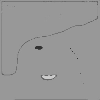

In [57]:
pc = cv2.imread('/content/results/chk.jpg',cv2.IMREAD_GRAYSCALE)
  #Resize the image
pc = cv2.resize(pc,(100,100))
pc = pc-1
cv2_imshow(pc)
#print(pc)

Model sent previously

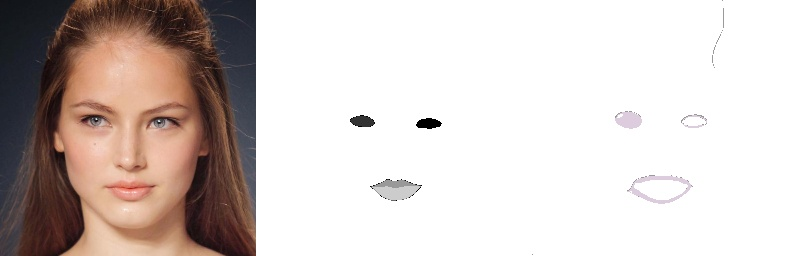

In [ ]:
cv2_imshow(cv2.imread("/content/results/25001.jpg"))

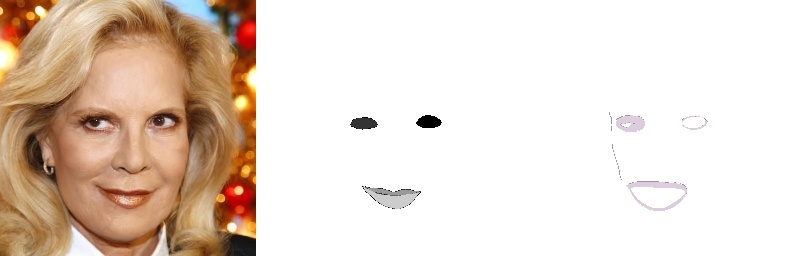

In [ ]:
cv2_imshow(cv2.imread("/content/results/25005.jpg"))

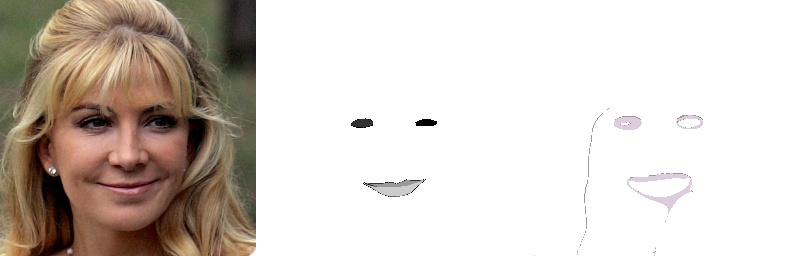

In [ ]:
cv2_imshow(cv2.imread("/content/results/25012.jpg"))

Recent Model

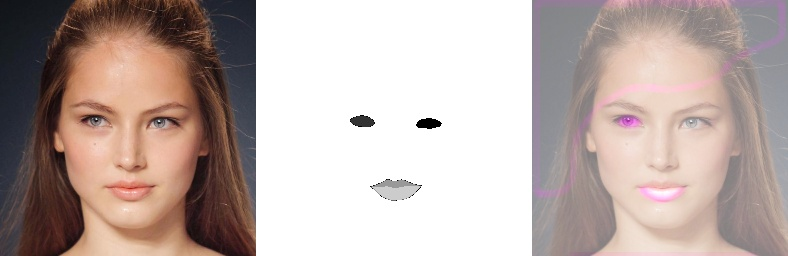

In [107]:
cv2_imshow(cv2.imread("/content/results/25001.jpg"))

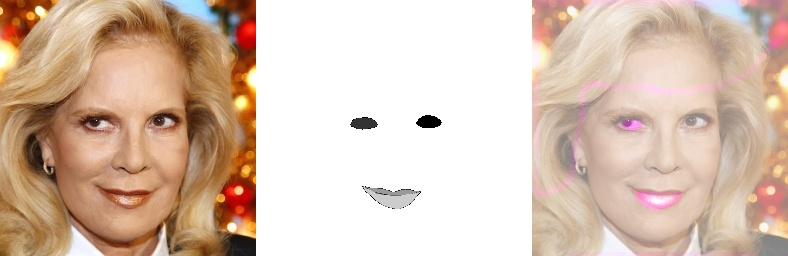

In [108]:
cv2_imshow(cv2.imread("/content/results/25005.jpg"))

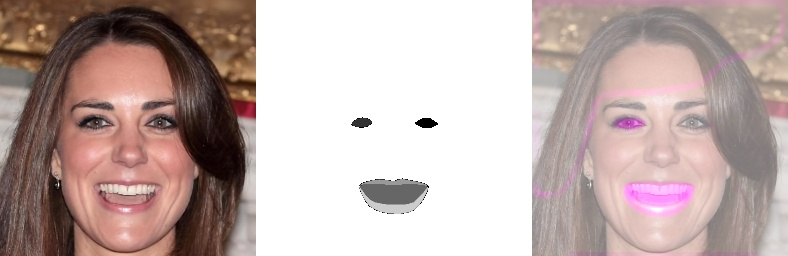

In [109]:
cv2_imshow(cv2.imread("/content/results/25010.jpg"))

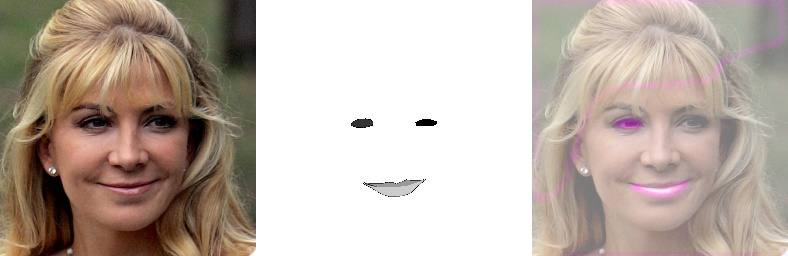

In [110]:
cv2_imshow(cv2.imread("/content/results/25012.jpg"))